# Import all packages and the used settings and functions

In [1]:
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')


from settings import Settings
from src.functions.data_preprocessing import *
from src.functions.functions_plot import *
from src.functions.regression_pipeline import *

settings = Settings()

# Load training and test dataset

In [2]:
# Load train and test dataset
df_train = pd.read_csv(settings.config['Data Locations'].get('train'))
df_validate = pd.read_csv(settings.config['Data Locations'].get('test'))

df_train.name = 'df_train'
df_validate.name = 'df_validate'

# Explore the data

First take a look at the training dataset
- what are the features and how many features does the training data include
- are the missing values (but take a deeper look at the data preperation process)
- what are the different units of the features

### Study each attribute and its characteristics

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

Get a report of the training and test dataset as csv


-> Use the function describe_report(df, name, output_file_path=None)

In [4]:
describe_report(df_train, output_file_path=settings.csv)
describe_report(df_validate, output_file_path=settings.csv)

Show if there are different columns in the training and test dataset. If there is only one difference, it is likely, that its the target variable. If there are columns in the test dataset, which are not in the training dataset, they have to be deleted, because the algorithm will not see them during the training.

-> Use the function column_diff(df_train, df_test)

In [5]:
column_diff(df_train, df_validate)

Columns in df_train not in df_validate
Index(['SalePrice'], dtype='object')
##################
Columns in df_validate not in df_train
Index([], dtype='object')


Create histograms of numeric features to see if a feature is skewed

-> Use the function create_histograms(df, output_file_path=None)

C:\Users\chris\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


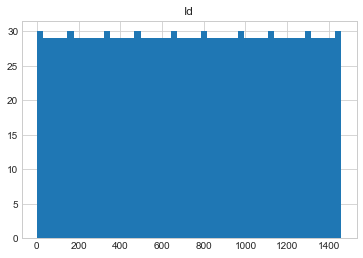

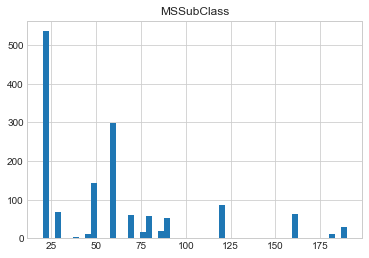

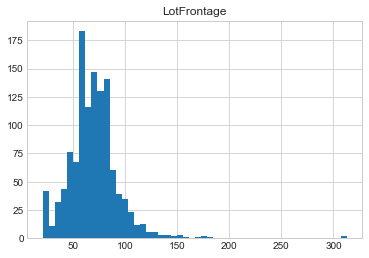

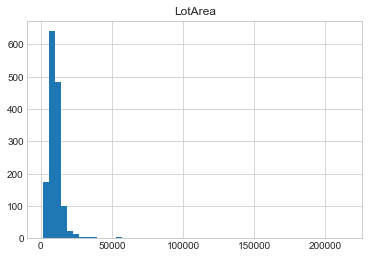

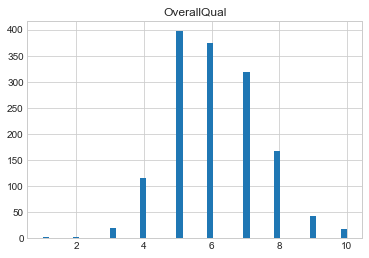

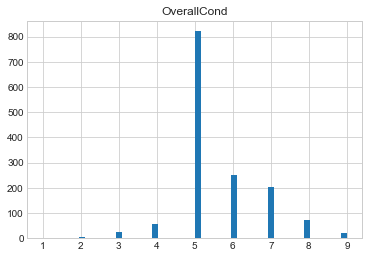

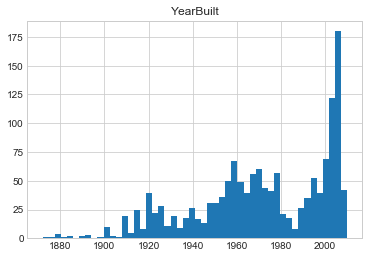

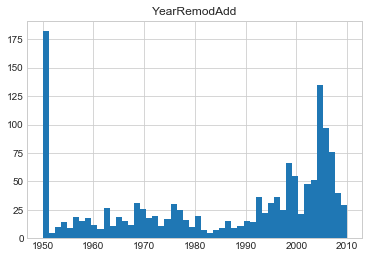

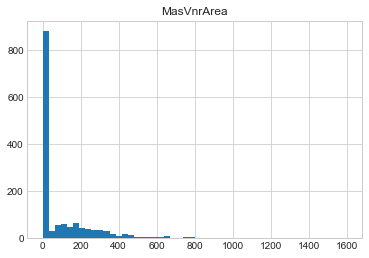

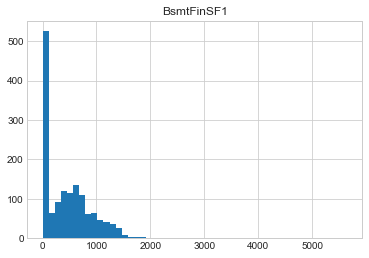

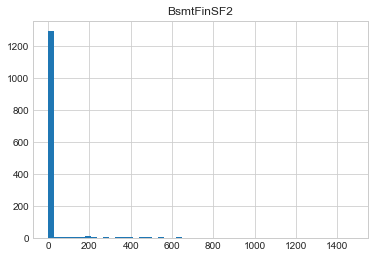

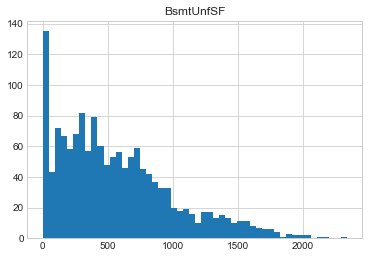

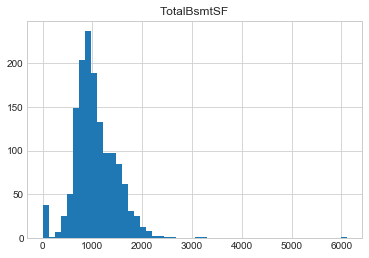

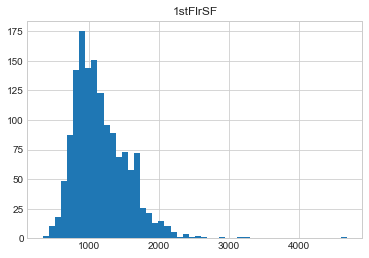

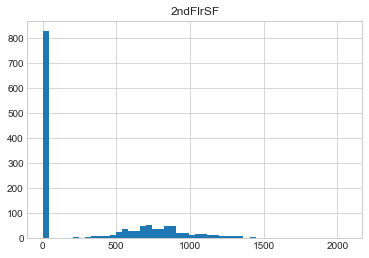

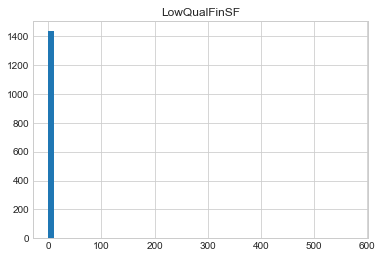

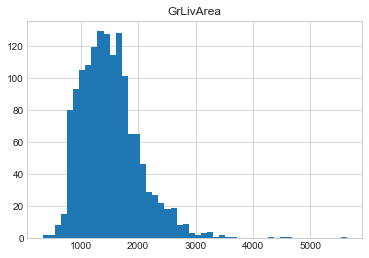

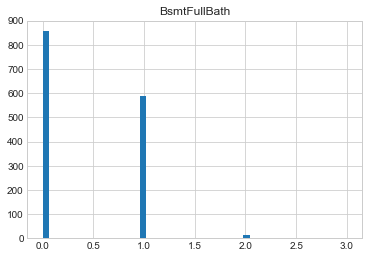

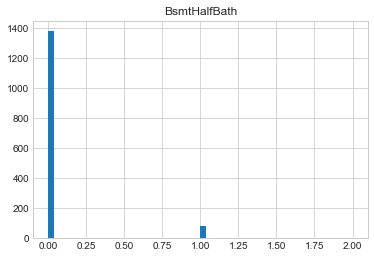

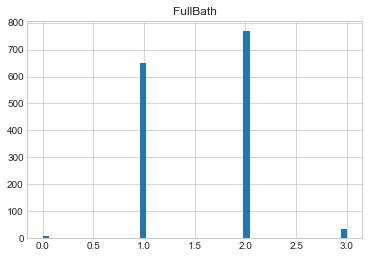

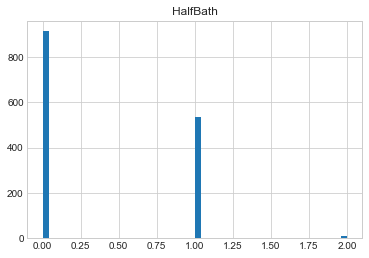

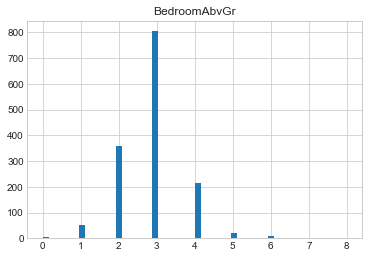

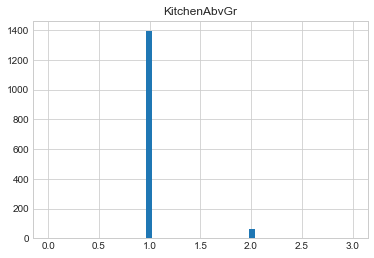

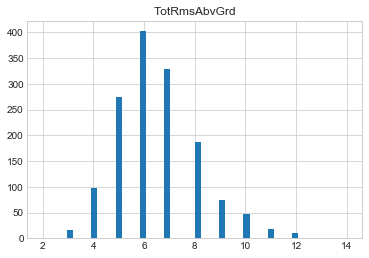

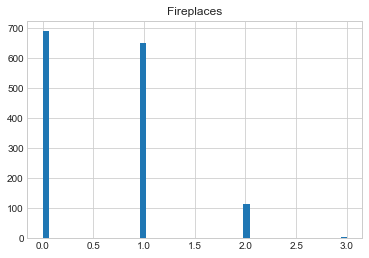

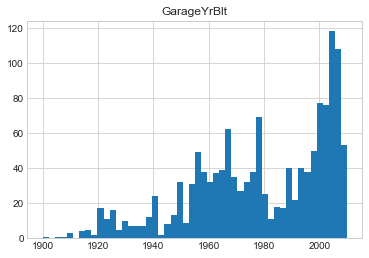

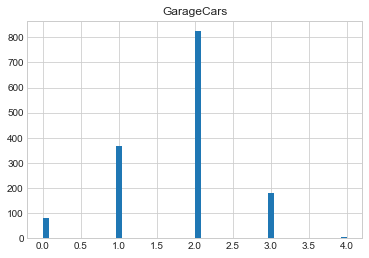

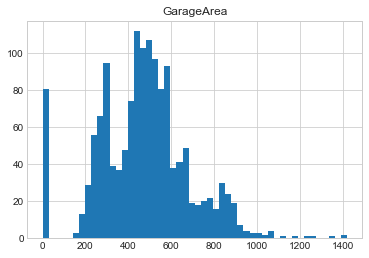

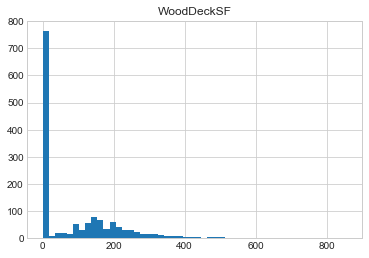

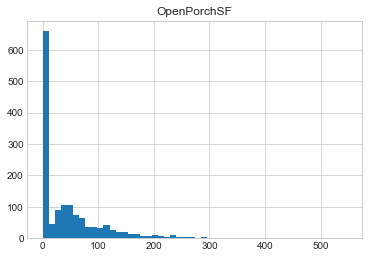

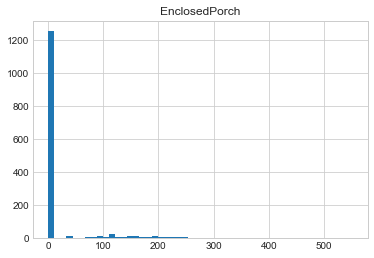

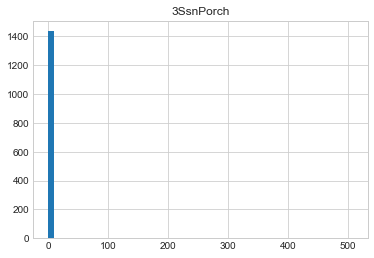

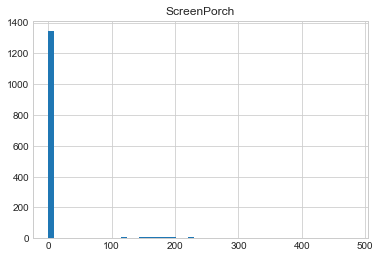

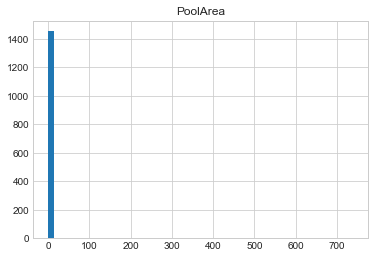

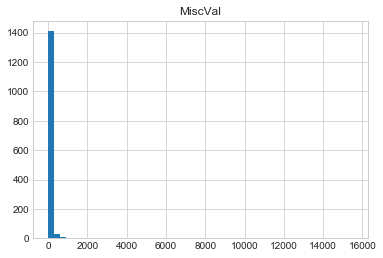

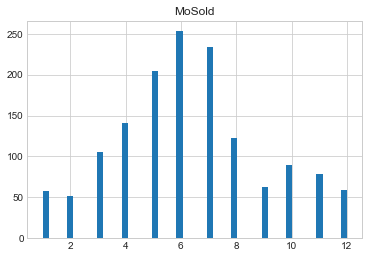

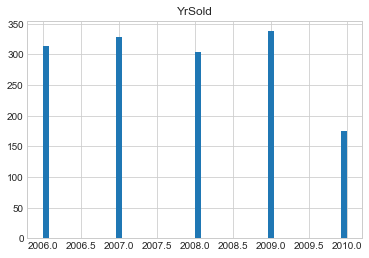

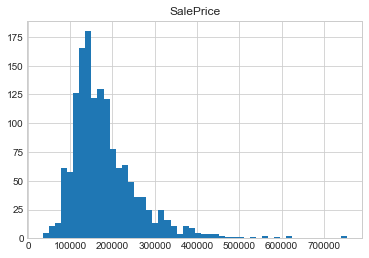

In [6]:
create_histograms(df_train, output_file_path=settings.figures)

The target variable "Sale Price" is left skewed -> try out transformation

### Study the correlations between attributes

In [7]:
corr_matrix = df_train.corr()
df_train.corr().round(2).to_csv(os.path.join(settings.csv, 'corr_matrix.csv'), decimal=",")
corr_matrix["SalePrice"].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

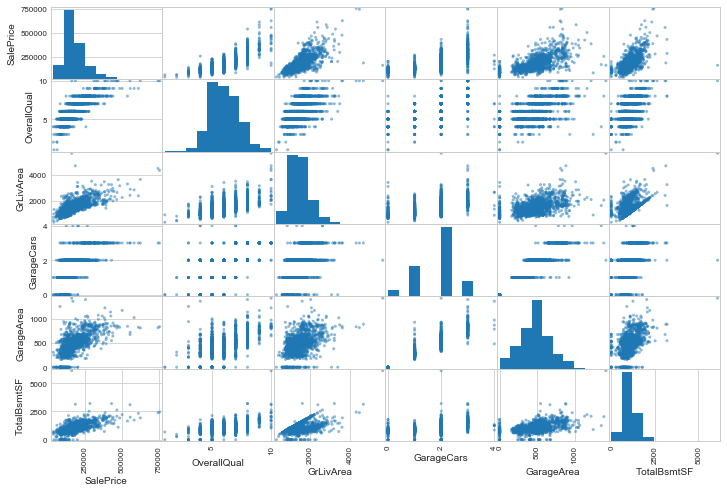

In [8]:
from pandas.plotting import scatter_matrix
corr_matrix_top = corr_matrix["SalePrice"].sort_values(ascending=False).index[:6]
scatter_matrix(df_train[corr_matrix_top], figsize =(12,8))
plt.savefig(os.path.join(settings.figures, 'scatter_matrix.pdf'))

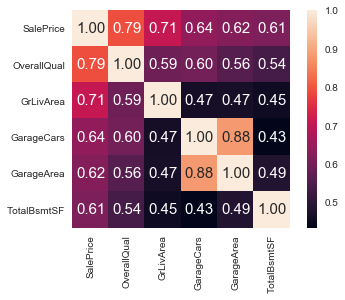

In [9]:
target_correlation(df_train, "SalePrice", 6, output_file_path=settings.csv)

# Data cleaning
See df_train_describe_numeric.csv for missing numerical values (< 1460)
LotFrontage	1201.0
MasVnrArea	1452.0
GarageYrBlt	1379.0
-> drop missing rows


See df_train_describe_categorical.csv for missing categorical values (< 1460)

MasVnrType	1452
BsmtQual	1423
BsmtCond	1423
BsmtExposure	1422
BsmtFinType1	1423
BsmtFinType2	1422
Electrical	1459
GarageType	1379
GarageFinish	1379
GarageQual	1379
GarageCond	1379
-> drop missing rows

PoolQC	7
Fence	281
MiscFeature	54
Alley	91
FireplaceQu	770
-> drop whole column

In [10]:
df_train.shape # Shape of df_train before cleaning

(1460, 81)

In [11]:
df_train.shape
df_train , df_validate = drop_missing_values(df_train, df_validate, None, output_file_path=settings.csv)

Missing values left: 0
Missing values left: 0


In [12]:
df_train.shape # Shape of df_train after cleaning missing values

(1338, 75)

In [13]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
outlier_features = list(df_train.select_dtypes(include=numerics))

C:\Users\chris\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


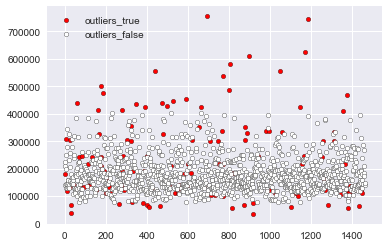

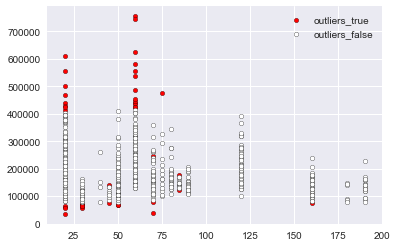

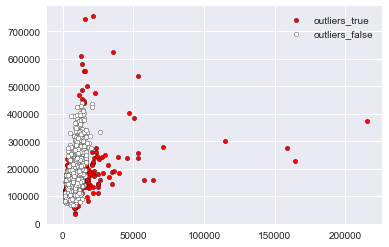

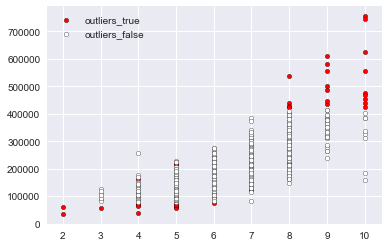

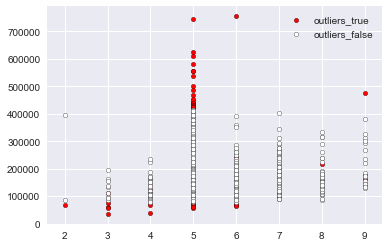

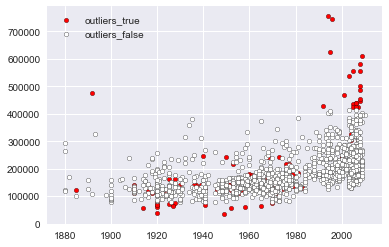

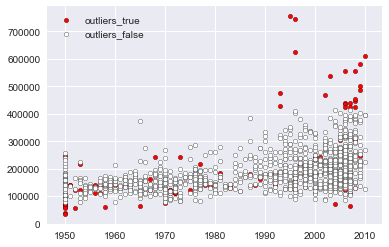

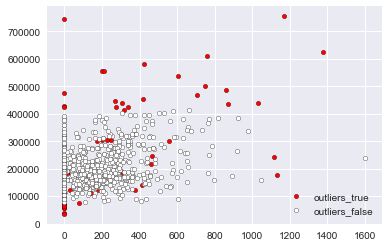

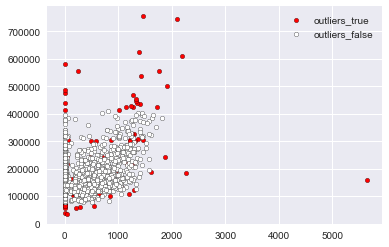

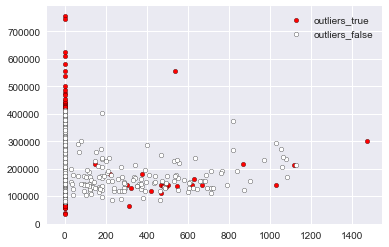

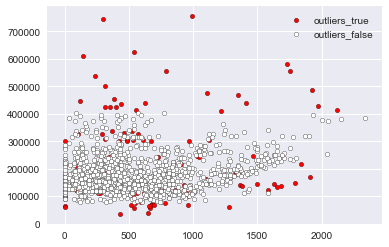

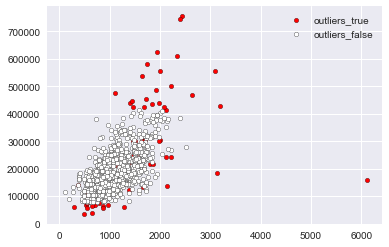

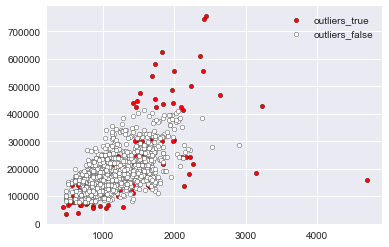

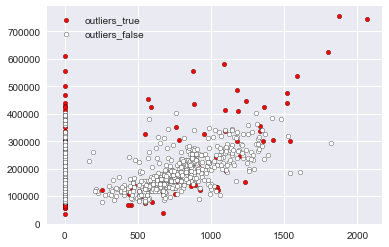

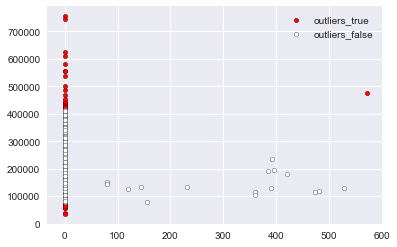

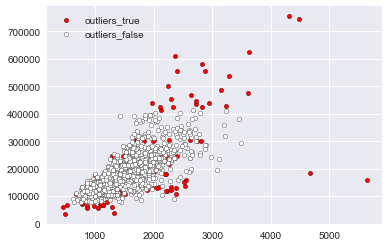

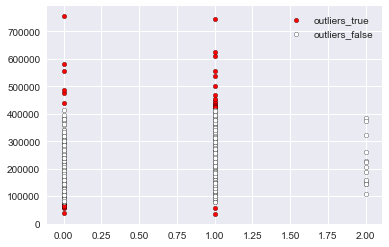

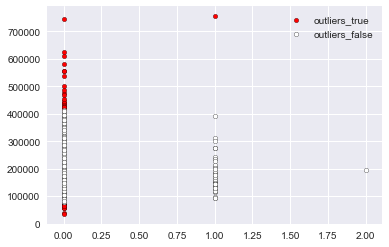

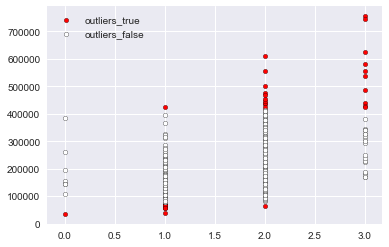

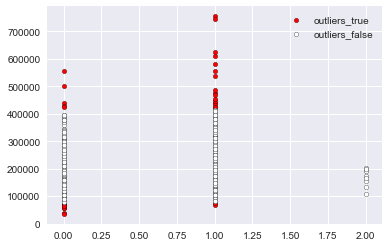

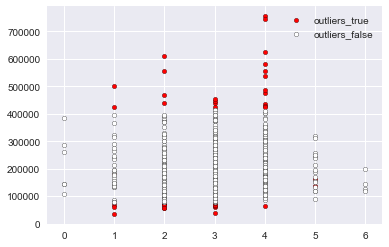

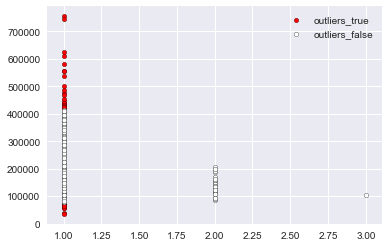

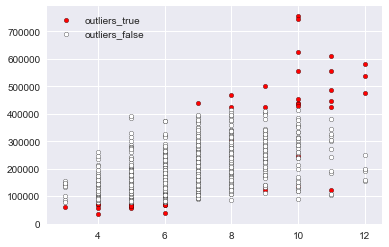

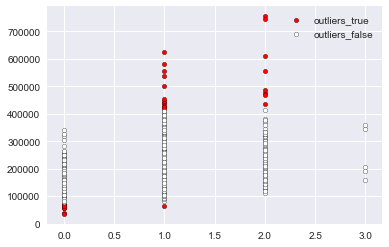

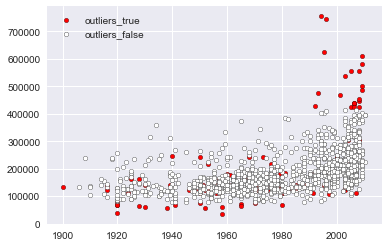

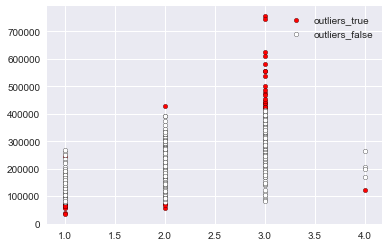

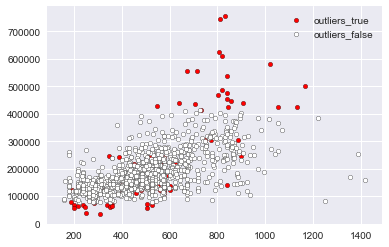

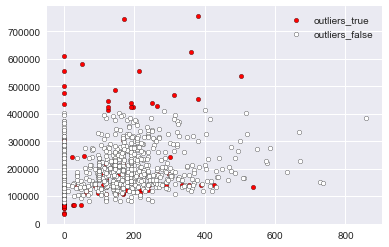

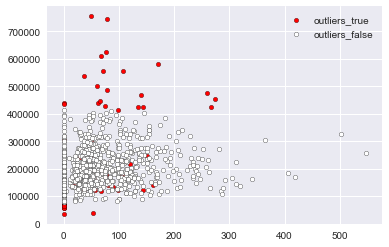

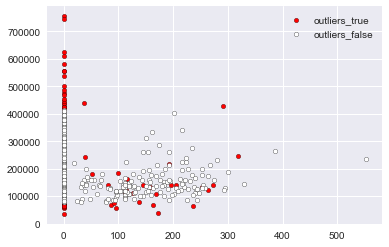

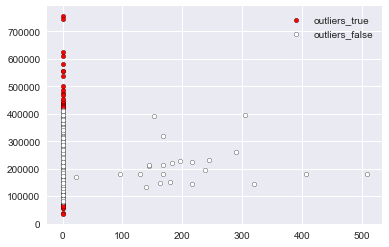

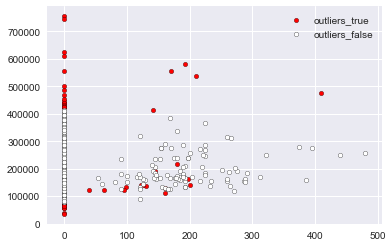

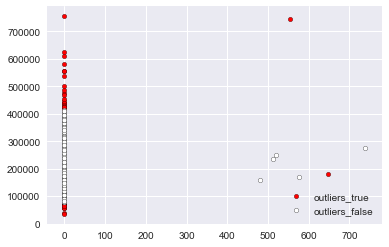

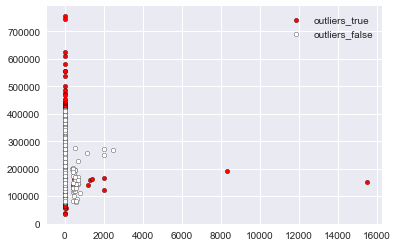

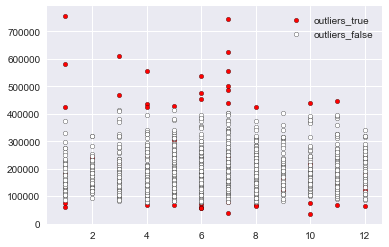

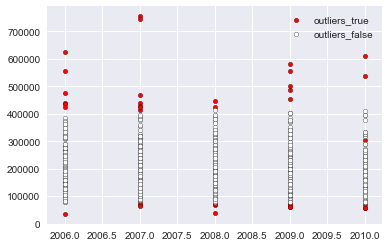

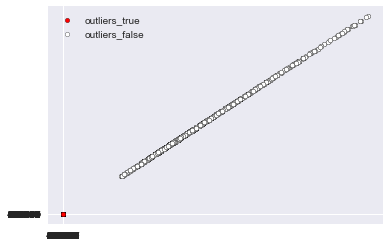

In [14]:
for outlier_feature in outlier_features:
    outlier_plot(df_train, outlier_feature, 'SalePrice', None, output_file_path=settings.figures)

- TotalBsmtSF > 6000 (1)
- MiscVal > 8000 (2)
- LotArea > 100000 (4)
- GrLivArea > 4000 ^ SalePrice < 200000 (2)
- BsmtFinSF1 > 5000 (1)
- 1stFlrSF > 4000 (1)

1338 - 11 = 1327

In [15]:
df_train = df_train[(df_train['TotalBsmtSF'] < 6000) & 
                    (df_train['MiscVal'] < 8000) &
                    (df_train['LotArea'] < 100000) &
                    ((df_train['GrLivArea'] < 4000) | (df_train['SalePrice'] > 200000)) &
                    (df_train['BsmtFinSF1'] < 5000) &
                    (df_train['1stFlrSF'] < 4000)
                   ]

In [16]:
df_train.shape # Shape of df_train after cleaning outliers

(1330, 75)

# Feature selection

# Feature engineering

Transform categorical features to numerical values

-> Use the function labelEnc(df)

In [17]:
df_train = labelEnc(df_train)
df_validate = labelEnc(df_validate)

# Feature scaling

log transform "Sale Price" because of left skewedness

In [18]:
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])

# Machine Learning Part

In [19]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df_train, test_size=0.2, random_state=42)

y_train = train_set['SalePrice']
x_train = train_set.drop(['Id','SalePrice'], axis=1)

y_test = test_set['SalePrice']
x_test = test_set.drop(['Id','SalePrice'], axis=1)

x_validate = df_validate

In [20]:
pipeline = Pipeline([
    ('reduce_dim', PCA()),
    ('feature_scaling', MinMaxScaler()), # scaling because linear models are sensitive to the scale of input features
    ('regression', Lasso()),
    ])

param_grid = [{'reduce_dim__n_components': [10, 20, 30, 40, 50, 60, 64],
               'regression__alpha': [0.0005, 0.005, 0.05, 0.5, 0.1]
              }]


In [21]:
pipe_best_params = regression_pipeline(x_train, y_train, pipeline, 5, 'r2', param_grid)

r2 Score: 0.729 (+/-0.120) for {'reduce_dim__n_components': 10, 'regression__alpha': 0.0005}
r2 Score: 0.658 (+/-0.123) for {'reduce_dim__n_components': 10, 'regression__alpha': 0.005}
r2 Score: -0.009 (+/-0.013) for {'reduce_dim__n_components': 10, 'regression__alpha': 0.05}
r2 Score: -0.009 (+/-0.013) for {'reduce_dim__n_components': 10, 'regression__alpha': 0.5}
r2 Score: -0.009 (+/-0.013) for {'reduce_dim__n_components': 10, 'regression__alpha': 0.1}
r2 Score: 0.831 (+/-0.055) for {'reduce_dim__n_components': 20, 'regression__alpha': 0.0005}
r2 Score: 0.724 (+/-0.092) for {'reduce_dim__n_components': 20, 'regression__alpha': 0.005}
r2 Score: -0.009 (+/-0.013) for {'reduce_dim__n_components': 20, 'regression__alpha': 0.05}
r2 Score: -0.009 (+/-0.013) for {'reduce_dim__n_components': 20, 'regression__alpha': 0.5}
r2 Score: -0.009 (+/-0.013) for {'reduce_dim__n_components': 20, 'regression__alpha': 0.1}
r2 Score: 0.842 (+/-0.051) for {'reduce_dim__n_components': 30, 'regression__alpha

In [22]:
pipe_best = Pipeline([
    ('reduce_dim', PCA(n_components = pipe_best_params['reduce_dim__n_components'])),
    ('feature_scaling', MinMaxScaler()),
    ('regression', Lasso(alpha = pipe_best_params['regression__alpha'])),
])

In [23]:
print(pipe_best_params['reduce_dim__n_components'])
print(pipe_best_params['regression__alpha'])

50
0.0005


     MSSubClass  MSZoning  LotArea  Street  LotShape  LandContour  Utilities  \
923         120         3     8012       1         3            3          0   

     LotConfig  LandSlope  Neighborhood      ...        OpenPorchSF  \
923          4          0            20      ...                 69   

     EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  MoSold  YrSold  \
923              0          0            0         0        0       7    2008   

     SaleType  SaleCondition  
923         8              4  

[1 rows x 73 columns]
      MSSubClass  MSZoning  LotArea  Street  LotShape  LandContour  Utilities  \
923          120         3     8012       1         3            3          0   
189          120         3     4923       1         3            3          0   
1037          60         3     9240       1         3            3          0   
506           60         3     9554       1         0            3          0   
230           20         3     8760       1

C:\Users\chris\Anaconda3\lib\site-packages\sklearn\decomposition\pca.py:423: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


      MSSubClass  MSZoning  LotArea  Street  LotShape  LandContour  Utilities  \
923          120         3     8012       1         3            3          0   
189          120         3     4923       1         3            3          0   
1037          60         3     9240       1         3            3          0   
506           60         3     9554       1         0            3          0   
230           20         3     8760       1         3            3          0   
356           20         3     9248       1         0            3          0   
154           30         4    11340       1         3            3          0   
1012          70         3    10592       1         3            3          0   
491           50         3     9490       1         3            3          0   
220           20         3     8990       1         0            3          0   
398           30         4     8967       1         3            3          0   
341           20         2  

      MSSubClass  MSZoning  LotArea  Street  LotShape  LandContour  Utilities  \
923          120         3     8012       1         3            3          0   
189          120         3     4923       1         3            3          0   
1037          60         3     9240       1         3            3          0   
506           60         3     9554       1         0            3          0   
230           20         3     8760       1         3            3          0   
356           20         3     9248       1         0            3          0   
154           30         4    11340       1         3            3          0   
1012          70         3    10592       1         3            3          0   
491           50         3     9490       1         3            3          0   
220           20         3     8990       1         0            3          0   
398           30         4     8967       1         3            3          0   
341           20         2  

      MSSubClass  MSZoning  LotArea  Street  LotShape  LandContour  Utilities  \
923          120         3     8012       1         3            3          0   
189          120         3     4923       1         3            3          0   
1037          60         3     9240       1         3            3          0   
506           60         3     9554       1         0            3          0   
230           20         3     8760       1         3            3          0   
356           20         3     9248       1         0            3          0   
154           30         4    11340       1         3            3          0   
1012          70         3    10592       1         3            3          0   
491           50         3     9490       1         3            3          0   
220           20         3     8990       1         0            3          0   
398           30         4     8967       1         3            3          0   
341           20         2  

      MSSubClass  MSZoning  LotArea  Street  LotShape  LandContour  Utilities  \
923          120         3     8012       1         3            3          0   
189          120         3     4923       1         3            3          0   
1037          60         3     9240       1         3            3          0   
506           60         3     9554       1         0            3          0   
230           20         3     8760       1         3            3          0   
356           20         3     9248       1         0            3          0   
154           30         4    11340       1         3            3          0   
1012          70         3    10592       1         3            3          0   
491           50         3     9490       1         3            3          0   
220           20         3     8990       1         0            3          0   
398           30         4     8967       1         3            3          0   
341           20         2  

      MSSubClass  MSZoning  LotArea  Street  LotShape  LandContour  Utilities  \
923          120         3     8012       1         3            3          0   
189          120         3     4923       1         3            3          0   
1037          60         3     9240       1         3            3          0   
506           60         3     9554       1         0            3          0   
230           20         3     8760       1         3            3          0   
356           20         3     9248       1         0            3          0   
154           30         4    11340       1         3            3          0   
1012          70         3    10592       1         3            3          0   
491           50         3     9490       1         3            3          0   
220           20         3     8990       1         0            3          0   
398           30         4     8967       1         3            3          0   
341           20         2  

[341 rows x 73 columns]
      MSSubClass  MSZoning  LotArea  Street  LotShape  LandContour  Utilities  \
923          120         3     8012       1         3            3          0   
189          120         3     4923       1         3            3          0   
1037          60         3     9240       1         3            3          0   
506           60         3     9554       1         0            3          0   
230           20         3     8760       1         3            3          0   
356           20         3     9248       1         0            3          0   
154           30         4    11340       1         3            3          0   
1012          70         3    10592       1         3            3          0   
491           50         3     9490       1         3            3          0   
220           20         3     8990       1         0            3          0   
398           30         4     8967       1         3            3          0   
341 

      MSSubClass  MSZoning  LotArea  Street  LotShape  LandContour  Utilities  \
923          120         3     8012       1         3            3          0   
189          120         3     4923       1         3            3          0   
1037          60         3     9240       1         3            3          0   
506           60         3     9554       1         0            3          0   
230           20         3     8760       1         3            3          0   
356           20         3     9248       1         0            3          0   
154           30         4    11340       1         3            3          0   
1012          70         3    10592       1         3            3          0   
491           50         3     9490       1         3            3          0   
220           20         3     8990       1         0            3          0   
398           30         4     8967       1         3            3          0   
341           20         2  

      MSSubClass  MSZoning  LotArea  Street  LotShape  LandContour  Utilities  \
923          120         3     8012       1         3            3          0   
189          120         3     4923       1         3            3          0   
1037          60         3     9240       1         3            3          0   
506           60         3     9554       1         0            3          0   
230           20         3     8760       1         3            3          0   
356           20         3     9248       1         0            3          0   
154           30         4    11340       1         3            3          0   
1012          70         3    10592       1         3            3          0   
491           50         3     9490       1         3            3          0   
220           20         3     8990       1         0            3          0   
398           30         4     8967       1         3            3          0   
341           20         2  

      MSSubClass  MSZoning  LotArea  Street  LotShape  LandContour  Utilities  \
923          120         3     8012       1         3            3          0   
189          120         3     4923       1         3            3          0   
1037          60         3     9240       1         3            3          0   
506           60         3     9554       1         0            3          0   
230           20         3     8760       1         3            3          0   
356           20         3     9248       1         0            3          0   
154           30         4    11340       1         3            3          0   
1012          70         3    10592       1         3            3          0   
491           50         3     9490       1         3            3          0   
220           20         3     8990       1         0            3          0   
398           30         4     8967       1         3            3          0   
341           20         2  

      MSSubClass  MSZoning  LotArea  Street  LotShape  LandContour  Utilities  \
923          120         3     8012       1         3            3          0   
189          120         3     4923       1         3            3          0   
1037          60         3     9240       1         3            3          0   
506           60         3     9554       1         0            3          0   
230           20         3     8760       1         3            3          0   
356           20         3     9248       1         0            3          0   
154           30         4    11340       1         3            3          0   
1012          70         3    10592       1         3            3          0   
491           50         3     9490       1         3            3          0   
220           20         3     8990       1         0            3          0   
398           30         4     8967       1         3            3          0   
341           20         2  

      MSSubClass  MSZoning  LotArea  Street  LotShape  LandContour  Utilities  \
923          120         3     8012       1         3            3          0   
189          120         3     4923       1         3            3          0   
1037          60         3     9240       1         3            3          0   
506           60         3     9554       1         0            3          0   
230           20         3     8760       1         3            3          0   
356           20         3     9248       1         0            3          0   
154           30         4    11340       1         3            3          0   
1012          70         3    10592       1         3            3          0   
491           50         3     9490       1         3            3          0   
220           20         3     8990       1         0            3          0   
398           30         4     8967       1         3            3          0   
341           20         2  

      MSSubClass  MSZoning  LotArea  Street  LotShape  LandContour  Utilities  \
923          120         3     8012       1         3            3          0   
189          120         3     4923       1         3            3          0   
1037          60         3     9240       1         3            3          0   
506           60         3     9554       1         0            3          0   
230           20         3     8760       1         3            3          0   
356           20         3     9248       1         0            3          0   
154           30         4    11340       1         3            3          0   
1012          70         3    10592       1         3            3          0   
491           50         3     9490       1         3            3          0   
220           20         3     8990       1         0            3          0   
398           30         4     8967       1         3            3          0   
341           20         2  

      MSSubClass  MSZoning  LotArea  Street  LotShape  LandContour  Utilities  \
923          120         3     8012       1         3            3          0   
189          120         3     4923       1         3            3          0   
1037          60         3     9240       1         3            3          0   
506           60         3     9554       1         0            3          0   
230           20         3     8760       1         3            3          0   
356           20         3     9248       1         0            3          0   
154           30         4    11340       1         3            3          0   
1012          70         3    10592       1         3            3          0   
491           50         3     9490       1         3            3          0   
220           20         3     8990       1         0            3          0   
398           30         4     8967       1         3            3          0   
341           20         2  

      MSSubClass  MSZoning  LotArea  Street  LotShape  LandContour  Utilities  \
923          120         3     8012       1         3            3          0   
189          120         3     4923       1         3            3          0   
1037          60         3     9240       1         3            3          0   
506           60         3     9554       1         0            3          0   
230           20         3     8760       1         3            3          0   
356           20         3     9248       1         0            3          0   
154           30         4    11340       1         3            3          0   
1012          70         3    10592       1         3            3          0   
491           50         3     9490       1         3            3          0   
220           20         3     8990       1         0            3          0   
398           30         4     8967       1         3            3          0   
341           20         2  

      MSSubClass  MSZoning  LotArea  Street  LotShape  LandContour  Utilities  \
923          120         3     8012       1         3            3          0   
189          120         3     4923       1         3            3          0   
1037          60         3     9240       1         3            3          0   
506           60         3     9554       1         0            3          0   
230           20         3     8760       1         3            3          0   
356           20         3     9248       1         0            3          0   
154           30         4    11340       1         3            3          0   
1012          70         3    10592       1         3            3          0   
491           50         3     9490       1         3            3          0   
220           20         3     8990       1         0            3          0   
398           30         4     8967       1         3            3          0   
341           20         2  

      MSSubClass  MSZoning  LotArea  Street  LotShape  LandContour  Utilities  \
923          120         3     8012       1         3            3          0   
189          120         3     4923       1         3            3          0   
1037          60         3     9240       1         3            3          0   
506           60         3     9554       1         0            3          0   
230           20         3     8760       1         3            3          0   
356           20         3     9248       1         0            3          0   
154           30         4    11340       1         3            3          0   
1012          70         3    10592       1         3            3          0   
491           50         3     9490       1         3            3          0   
220           20         3     8990       1         0            3          0   
398           30         4     8967       1         3            3          0   
341           20         2  

      MSSubClass  MSZoning  LotArea  Street  LotShape  LandContour  Utilities  \
923          120         3     8012       1         3            3          0   
189          120         3     4923       1         3            3          0   
1037          60         3     9240       1         3            3          0   
506           60         3     9554       1         0            3          0   
230           20         3     8760       1         3            3          0   
356           20         3     9248       1         0            3          0   
154           30         4    11340       1         3            3          0   
1012          70         3    10592       1         3            3          0   
491           50         3     9490       1         3            3          0   
220           20         3     8990       1         0            3          0   
398           30         4     8967       1         3            3          0   
341           20         2  

[891 rows x 73 columns]
      MSSubClass  MSZoning  LotArea  Street  LotShape  LandContour  Utilities  \
923          120         3     8012       1         3            3          0   
189          120         3     4923       1         3            3          0   
1037          60         3     9240       1         3            3          0   
506           60         3     9554       1         0            3          0   
230           20         3     8760       1         3            3          0   
356           20         3     9248       1         0            3          0   
154           30         4    11340       1         3            3          0   
1012          70         3    10592       1         3            3          0   
491           50         3     9490       1         3            3          0   
220           20         3     8990       1         0            3          0   
398           30         4     8967       1         3            3          0   
341 

      MSSubClass  MSZoning  LotArea  Street  LotShape  LandContour  Utilities  \
923          120         3     8012       1         3            3          0   
189          120         3     4923       1         3            3          0   
1037          60         3     9240       1         3            3          0   
506           60         3     9554       1         0            3          0   
230           20         3     8760       1         3            3          0   
356           20         3     9248       1         0            3          0   
154           30         4    11340       1         3            3          0   
1012          70         3    10592       1         3            3          0   
491           50         3     9490       1         3            3          0   
220           20         3     8990       1         0            3          0   
398           30         4     8967       1         3            3          0   
341           20         2  

      MSSubClass  MSZoning  LotArea  Street  LotShape  LandContour  Utilities  \
923          120         3     8012       1         3            3          0   
189          120         3     4923       1         3            3          0   
1037          60         3     9240       1         3            3          0   
506           60         3     9554       1         0            3          0   
230           20         3     8760       1         3            3          0   
356           20         3     9248       1         0            3          0   
154           30         4    11340       1         3            3          0   
1012          70         3    10592       1         3            3          0   
491           50         3     9490       1         3            3          0   
220           20         3     8990       1         0            3          0   
398           30         4     8967       1         3            3          0   
341           20         2  

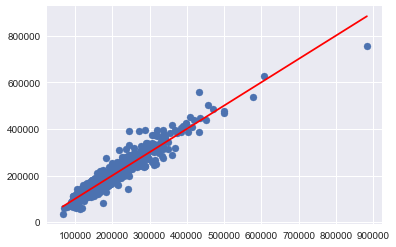

In [24]:
train_errors = evaluate_pipe_best_train(x_train, y_train, pipe_best, 'Lasso', log=True, output_file_path=settings.figures)

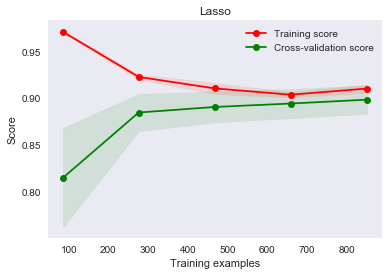

In [25]:
plot_learning_curve(pipe_best, 'Lasso', x_train, y_train, 'r2', output_file_path=settings.figures)

# Evaluate the System on the Test Set

Evaluate the model with the test_set

-> Use the function evaluate_pipe_best_test(x_train, y_train, pipe_best, algo, output_file_path=None)

R2: 0.8879895336812639
RMSE: 26886.837979851225


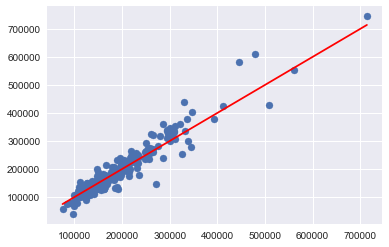

In [26]:
evaluate_pipe_best_test(x_test, y_test, pipe_best, 'Lasso', log=True, output_file_path=settings.figures)

## Best results
- pipe_best_params['reduce_dim__n_components'] == 50
- pipe_best_params['regression__alpha'] == 0.0005


### Training
- R2: 0.9132763394820593
- RMSE: 21171.57323580308


### Test
- R2: 0.8879895336812639
- RMSE: 26886.837979851225